In [54]:
import pandas as pd

# Load the uploaded Excel file to check its structure
file_path = '../dataset/rab107row.xlsx'
data = pd.read_excel(file_path)

In [55]:
data.shape

(107, 12)

In [56]:
data.head()

,namaproyek,rab,waktu,provinsi,tahun,luas,subitem,tinggi,lantai,ikk,ihbp,inflasi
0,Gedung Apartemen,2.641914e+10,196,Jawa Barat,2019,17401.00,4,21.8,6,103.03,143.72,3.21
1,Gedung Apartemen,8.821079e+10,273,DKI Jakarta,2022,16320.59,6,47.6,14,121.48,107.66,4.21
2,Gedung Apartemen,8.171200e+10,348,DKI Jakarta,2023,23688.00,5,34.0,10,116.73,113.88,2.28
3,Gedung Apartemen,3.690000e+11,830,Banten,2021,55000.00,6,49.8,16,97.64,109.64,1.91
4,Gedung Apartemen,5.400316e+11,700,DKI Jakarta,2023,150000.00,6,105.0,30,116.73,113.88,2.28


In [57]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import BayesianRidge, Lasso, LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [58]:
# Label encoding kolom 'Provinsi' dan nama proyek karena nilainya kategorikal
label_encoder = LabelEncoder()
data['label_provinsi'] = label_encoder.fit_transform(data['provinsi'])
data['label_namaproyek'] = label_encoder.fit_transform(data['namaproyek'])

# Melihat nilai unik dari hasil encoding kolom 'provinsi_encoded'
provinsi_unik = data[['provinsi', 'label_provinsi']].drop_duplicates().sort_values(
    by='label_provinsi')

# Melihat nilai unik dari hasil encoding kolom 'namaproyek_encoded'
namaproyek_unik = data[['namaproyek', 'label_namaproyek']].drop_duplicates().sort_values(
    by='label_namaproyek')

In [59]:
data['rab'] = data['rab'].apply(lambda x: np.log1p(x))

In [60]:
# 4. Normalisasi Kolom Numerik
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

numerical_columns = ['waktu', 'tahun', 'luas', 'subitem', 
                     'tinggi', 'lantai', 'ikk', 'ihbp', 'inflasi']
# 4. Normalisasi Kolom Numerik
scalerStandard = StandardScaler()
data[numerical_columns] = scalerStandard.fit_transform(data[numerical_columns])

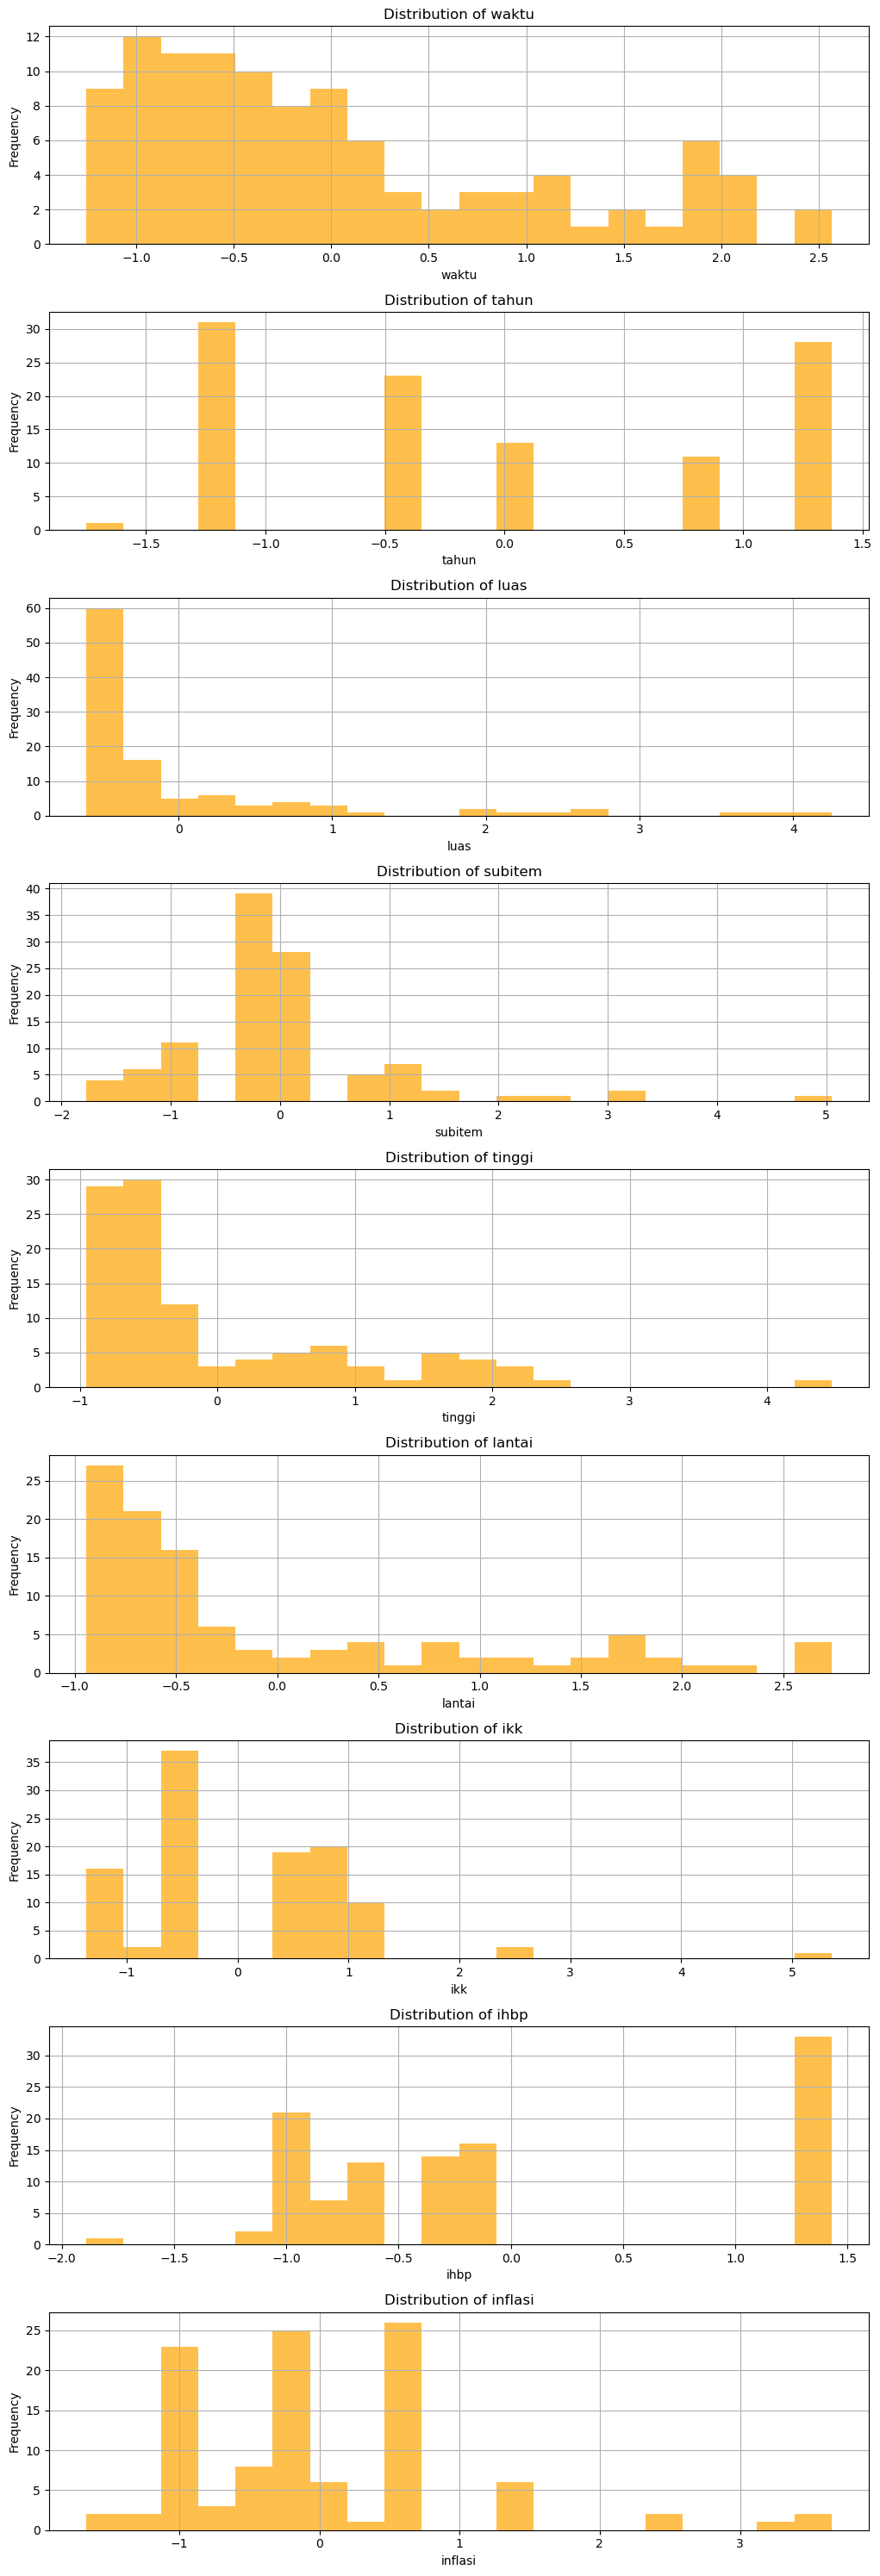

In [61]:
# Compare distributions before and after transformation using histograms
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 30))
for i, col in enumerate(numerical_columns, 1):

    # Transformed data
    plt.subplot(len(numerical_columns), 2, 2 * i)
    data[col].hist(bins=20, alpha=0.7, color='orange')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Standard Scaler dulu

In [62]:
cekduplikat = data[data.duplicated()]
cekduplikat

,namaproyek,rab,waktu,provinsi,tahun,luas,subitem,tinggi,lantai,ikk,ihbp,inflasi,label_provinsi,label_namaproyek
22,Gedung Apartemen,26.146404,1.888984,Banten,-0.50146,0.151261,-0.309622,1.627211,1.818659,-1.249648,-1.013604,-1.108159,1,0


In [63]:
transformed_data = data.drop_duplicates()

cekduplikat = transformed_data[transformed_data.duplicated()]
cekduplikat, transformed_data.shape

(Empty DataFrame
 Columns: [namaproyek, rab, waktu, provinsi, tahun, luas, subitem, tinggi, lantai, ikk, ihbp, inflasi, label_provinsi, label_namaproyek]
 Index: [],
 (106, 14))

In [64]:
# Fungsi untuk mendeteksi outlier menggunakan metode IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Analisis outlier untuk setiap kolom numerik
outlier_results = {}
for col in numerical_columns:
    outliers, lower, upper = detect_outliers_iqr(transformed_data, col)
    outlier_results[col] = {
        "outliers_count": len(outliers),
        "lower_bound": lower,
        "upper_bound": upper
    }

# Menampilkan hasil analisis outlier
outlier_results

{'waktu': {'outliers_count': 2,
  'lower_bound': -2.642240271284731,
  'upper_bound': 2.3066578928838233},
 'tahun': {'outliers_count': 0,
  'lower_bound': -4.868825356933376,
  'upper_bound': 5.113724356922785},
 'luas': {'outliers_count': 15,
  'lower_bound': -1.3327573185857235,
  'upper_bound': 0.7309566997233525},
 'subitem': {'outliers_count': 24,
  'lower_bound': -1.0404220910101611,
  'upper_bound': 0.9083772742079966},
 'tinggi': {'outliers_count': 4,
  'lower_bound': -2.4209862124330366,
  'upper_bound': 2.1301943986254086},
 'lantai': {'outliers_count': 5,
  'lower_bound': -2.4962470984967,
  'upper_bound': 2.198370716174904},
 'ikk': {'outliers_count': 1,
  'lower_bound': -2.678788125819649,
  'upper_bound': 2.6964256031621683},
 'ihbp': {'outliers_count': 0,
  'lower_bound': -4.070368134383643,
  'upper_bound': 4.7284272307261155},
 'inflasi': {'outliers_count': 3,
  'lower_bound': -2.5359573003222637,
  'upper_bound': 2.4237631150551247}}

In [65]:
# Fungsi untuk mendeteksi dan menghapus baris yang mengandung outlier
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Hapus baris yang memiliki nilai outlier
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Hapus outlier untuk setiap kolom numerik
data_cleaned = transformed_data.copy()
for col in numerical_columns:
    data_cleaned = remove_outliers_iqr(data_cleaned, col)

In [66]:
data_cleaned.shape

(50, 14)

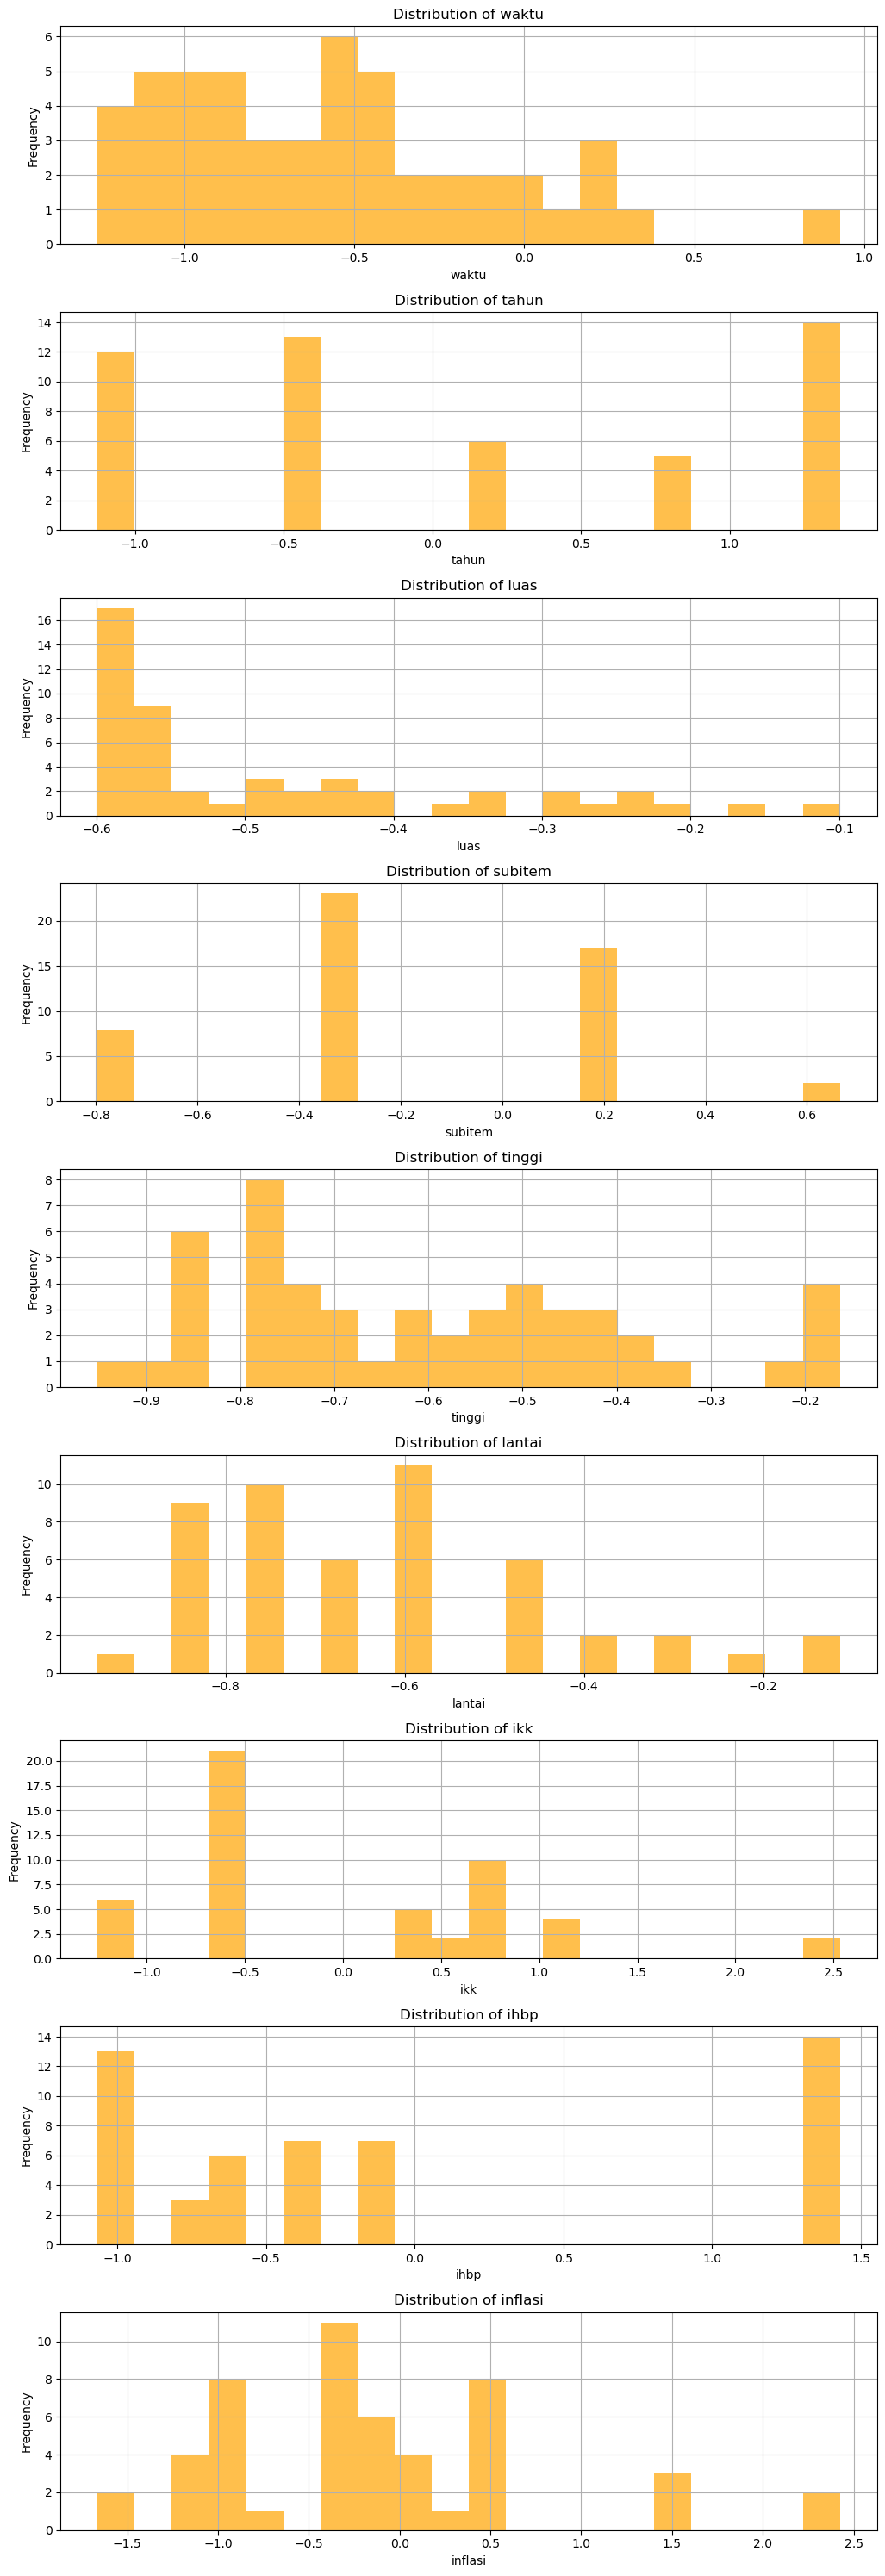

In [67]:
plt.figure(figsize=(20, 30))
for i, col in enumerate(numerical_columns, 1):

    # Transformed data
    plt.subplot(len(numerical_columns), 2, 2 * i)
    data_cleaned[col].hist(bins=20, alpha=0.7, color='orange')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [68]:
data_cleaned.head()

,namaproyek,rab,waktu,provinsi,tahun,luas,subitem,tinggi,lantai,ikk,ihbp,inflasi,label_provinsi,label_namaproyek
0,Gedung Apartemen,23.997354,-0.810415,Jawa Barat,-1.125369,-0.238173,-0.796822,-0.512854,-0.482624,-0.663083,1.428879,0.545081,3,0
2,Gedung Apartemen,25.126467,-0.042047,DKI Jakarta,1.370268,-0.099595,-0.309622,-0.212234,-0.114419,0.680720,-0.391393,-0.328506,2,0
5,Gedung Apartemen,24.660967,0.165211,Jawa Barat,1.370268,-0.430176,0.177578,-0.447555,-0.298522,-0.560091,-0.152269,-0.140638,3,0
6,Gedung Apartemen,23.608067,-0.860966,DKI Jakarta,0.122449,-0.506656,0.177578,-0.453716,-0.574676,1.140752,-0.650038,-1.033012,2,0
10,Gedung Apartemen,25.517246,0.114660,Jawa Barat,-1.125369,-0.342855,0.177578,-0.187594,-0.114419,-0.663083,1.428879,0.545081,3,0


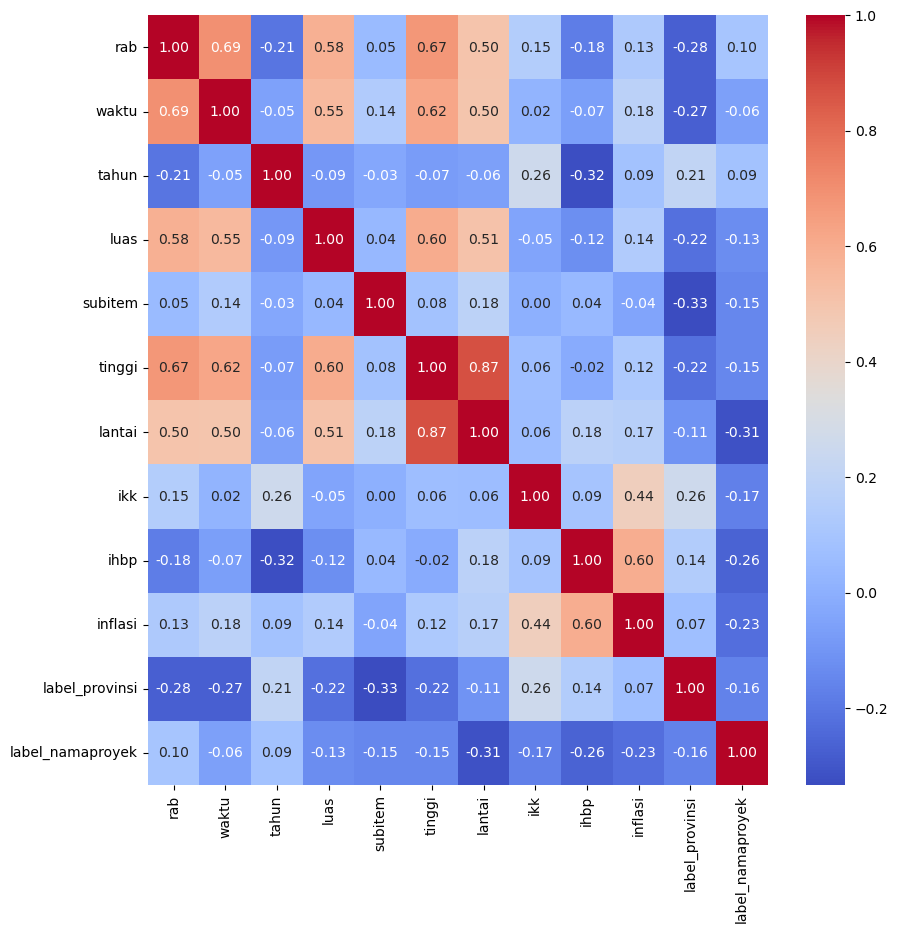

In [69]:
# Digunakan untuk membuat visualisasi dalam bentuk grafik atau plot
import seaborn as sns
import matplotlib.pyplot as plt
# Visualisasi korelasi antar fitur atau kolom apakah saling berpengaruh atau tidak
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(data_cleaned.corr(numeric_only=True), 
            annot=True, cmap='coolwarm', fmt='.2f', ax=ax)
plt.show()

In [82]:
# Split data into features and target
X1 = data_cleaned.drop(columns=['rab', 'namaproyek', 'provinsi', 'lantai'])
y1 = data_cleaned['rab']

# Split into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X1, y1, 
    test_size=0.3, 
    random_state=42)

# Split into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X1, y1, 
    test_size=0.2, 
    random_state=42)

In [83]:
# Initialize models
models1 = {
    'AdaBoost': AdaBoostRegressor(),
    'Bayesian Ridge': BayesianRidge(),
    'Decision Tree': DecisionTreeRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'KNN Regressor': KNeighborsRegressor(),
    'Lasso Regression': Lasso(),
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Ridge Regression': Ridge(),
    'SVR': SVR(),
    'XGBoost': xgb.XGBRegressor()
}

models2 = {
    'AdaBoost': AdaBoostRegressor(),
    'Bayesian Ridge': BayesianRidge(),
    'Decision Tree': DecisionTreeRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'KNN Regressor': KNeighborsRegressor(),
    'Lasso Regression': Lasso(),
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Ridge Regression': Ridge(),
    'SVR': SVR(),
    'XGBoost': xgb.XGBRegressor()
}

# 70:30
# Train and evaluate each model with additional metrics
results1 = []
for name1, model1 in models1.items():
    # Fit model to training data
    model1.fit(X_train1, y_train1)
    
    # Predict on training data
    y_train_pred1 = model1.predict(X_train1)
    
    # Predict on testing data
    y_pred1 = model1.predict(X_test1)
    
    # Calculate metrics for training data
    r2_train1 = r2_score(y_train1, y_train_pred1)
    
    # Calculate metrics for testing data
    mse1 = mean_squared_error(y_test1, y_pred1)
    mae1 = mean_absolute_error(y_test1, y_pred1)
    r21 = r2_score(y_test1, y_pred1)
    
    # Append results
    results1.append({
        'Model': name1,
        'Training R2 Score': r2_train1,
        'Testing RMSE': np.sqrt(mse1),
        'Testing MAE': mae1,
        'Testing R2 Score': r21
    })

# Convert results into a DataFrame for better visualization
results_df1 = pd.DataFrame(results1).sort_values(by='Testing R2 Score', ascending=False)

# 80:20
# Train and evaluate each model with additional metrics
results2 = []
for name2, model2 in models2.items():
    # Fit model to training data
    model2.fit(X_train2, y_train2)
    
    # Predict on training data
    y_train_pred2 = model2.predict(X_train2)
    
    # Predict on testing data
    y_pred2 = model2.predict(X_test2)
    
    # Calculate metrics for training data
    r2_train2 = r2_score(y_train2, y_train_pred2)
    
    # Calculate metrics for testing data
    mse2 = mean_squared_error(y_test2, y_pred2)
    mae2 = mean_absolute_error(y_test2, y_pred2)
    r22 = r2_score(y_test2, y_pred2)
    
    # Append results
    results2.append({
        'Model': name2,
        'Training R2 Score': r2_train2,
        'Testing RMSE': np.sqrt(mse2),
        'Testing MAE': mae2,
        'Testing R2 Score': r22
    })

# Convert results into a DataFrame for better visualization
results_df2 = pd.DataFrame(results2).sort_values(by='Testing R2 Score', ascending=False)


In [84]:
results_df1

,Model,Training R2 Score,Testing RMSE,Testing MAE,Testing R2 Score
0,AdaBoost,0.955971,0.776198,0.653144,0.646145
7,Random Forest,0.937916,0.850379,0.636470,0.575278
8,Ridge Regression,0.783603,0.950113,0.800597,0.469811
6,Linear Regression,0.804724,0.955474,0.792886,0.463811
1,Bayesian Ridge,0.778624,0.956277,0.807538,0.462909
10,XGBoost,1.000000,1.119756,0.852746,0.263578
3,Gradient Boosting,0.999882,1.140502,0.841861,0.236037
5,Lasso Regression,0.033187,1.332927,1.015968,-0.043501
2,Decision Tree,1.000000,1.360585,0.892612,-0.087255
4,KNN Regressor,0.321958,1.415021,0.963671,-0.175996


In [85]:
results_df2

,Model,Training R2 Score,Testing RMSE,Testing MAE,Testing R2 Score
0,AdaBoost,0.956122,0.767733,0.639773,0.703858
7,Random Forest,0.935107,0.967573,0.740723,0.529622
6,Linear Regression,0.800146,0.997374,0.824870,0.500201
1,Bayesian Ridge,0.780013,0.999151,0.813357,0.498418
8,Ridge Regression,0.779769,0.999410,0.813519,0.498159
3,Gradient Boosting,0.999673,1.085334,0.842579,0.408157
5,Lasso Regression,0.000000,1.419697,1.060990,-0.012676
10,XGBoost,1.000000,1.449830,1.037677,-0.056120
9,SVR,0.415276,1.500737,0.984965,-0.131589
4,KNN Regressor,0.352329,1.552442,1.015434,-0.210905


In [88]:
# Select a model to use for predictions (e.g., AdaBoost)
top_model = AdaBoostRegressor() #80:20
top_model.fit(X_train2, y_train2)

# Make predictions using the selected model
y_test_pred = top_model.predict(X_test2)

# Create a DataFrame to compare actual and predicted values
comparison_df = pd.DataFrame({
    'Actual Value': y_test2,
    'Predicted Value': y_test_pred
}).reset_index(drop=True)

comparison_df

,Actual Value,Predicted Value
0,23.914647,23.498070
1,24.304149,23.997354
2,24.569757,23.705935
3,22.478156,22.984856
4,25.635921,25.018070
5,24.785578,23.462154
6,23.107083,24.436649
7,24.897653,24.844947
8,20.504349,21.888268
9,24.472770,24.476694


In [89]:
comparison_df['Error'] = comparison_df['Actual Value'] - comparison_df['Predicted Value']
comparison_df.head(10)

,Actual Value,Predicted Value,Error
0,23.914647,23.498070,0.416577
1,24.304149,23.997354,0.306795
2,24.569757,23.705935,0.863822
3,22.478156,22.984856,-0.506699
4,25.635921,25.018070,0.617851
5,24.785578,23.462154,1.323424
6,23.107083,24.436649,-1.329566
7,24.897653,24.844947,0.052706
8,20.504349,21.888268,-1.383919
9,24.472770,24.476694,-0.003924


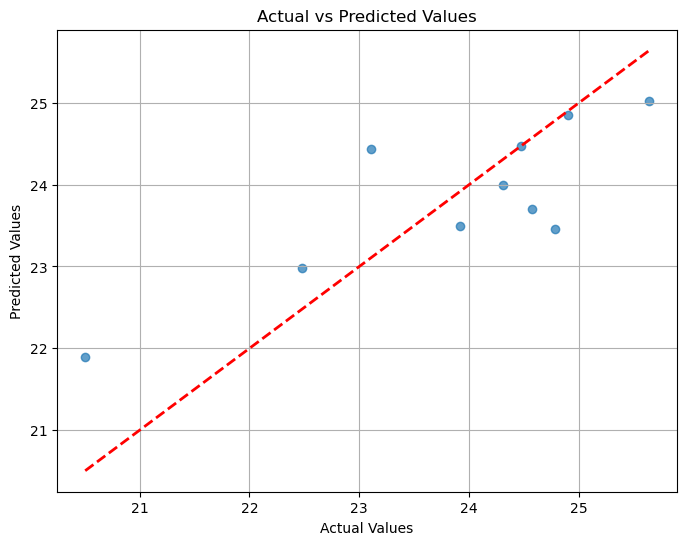

In [90]:
import matplotlib.pyplot as plt

# Scatter plot untuk nilai aktual vs prediksi
plt.figure(figsize=(8, 6))
plt.scatter(y_test2, y_test_pred, alpha=0.7)
plt.plot([min(y_test2), max(y_test2)], 
         [min(y_test2), max(y_test2)], 
         color='red', linestyle='--', linewidth=2)  # Garis diagonal
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.grid()
plt.show()

In [91]:
from sklearn.model_selection import cross_val_score

# Lakukan cross-validation dengan 5 fold
cv_scores = cross_val_score(top_model, X1, y1, cv=5, scoring='r2')

# Cetak hasil cross-validation
print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean R²: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation: {np.std(cv_scores):.4f}")

Cross-Validation R² Scores: [ 0.54894818  0.63650202 -0.49455022  0.68674342  0.35814957]
Mean R²: 0.3472
Standard Deviation: 0.4355


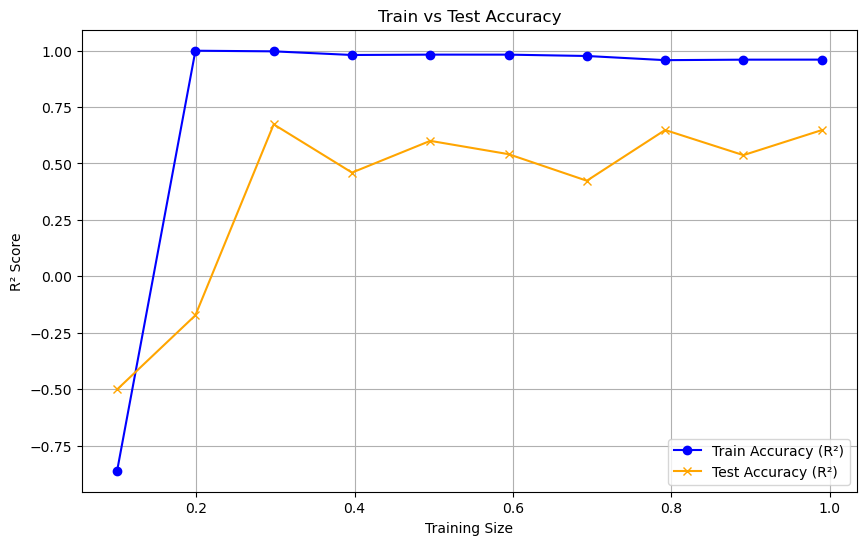

In [94]:
from sklearn.metrics import r2_score

# Ukuran subset data training (10% hingga 100%)
train_sizes = np.linspace(0.1, 0.99, 10)

train_scores = []
test_scores = []

for train_size in train_sizes:
    # Split subset data training
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train2, y_train2, train_size=train_size, random_state=42)
    
    # Latih model
    top_model.fit(X_train_subset, y_train_subset)
    
    # Evaluasi akurasi pada data training
    y_train_pred = top_model.predict(X_train_subset)
    train_scores.append(r2_score(y_train_subset, y_train_pred))
    
    # Evaluasi akurasi pada data testing
    y_test_pred = top_model.predict(X_test2)
    test_scores.append(r2_score(y_test2, y_test_pred))

# Plot grafik Train vs Test Accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores, label='Train Accuracy (R²)', marker='o', color='blue')
plt.plot(train_sizes, test_scores, label='Test Accuracy (R²)', marker='x', color='orange')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title('Train vs Test Accuracy')
plt.legend()
plt.grid()
plt.show()

In [97]:
from sklearn.metrics import mean_squared_error, r2_score

# Evaluasi akurasi pada data training
pred_latih = top_model.predict(X_train2)
r2_train = r2_score(y_train2, pred_latih)
rmse_train = np.sqrt(mean_squared_error(y_train2, pred_latih))

# Evaluasi akurasi pada data training
pred_test = top_model.predict(X_test2)
r2_test = r2_score(y_test2, pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test2, pred_test))

# Cetak hasil
print("Training Set:")
print(f"R² Score: {r2_train}")
print(f"Mean Squared Error: {rmse_train}")

print("\nTesting Set:")
print(f"R² Score: {r2_test}")
print(f"Mean Squared Error: {rmse_test}")

Training Set:
R² Score: 0.946063894468441
Mean Squared Error: 0.31064923829458674

Testing Set:
R² Score: 0.6474266920755862
Mean Squared Error: 0.8376931629326966


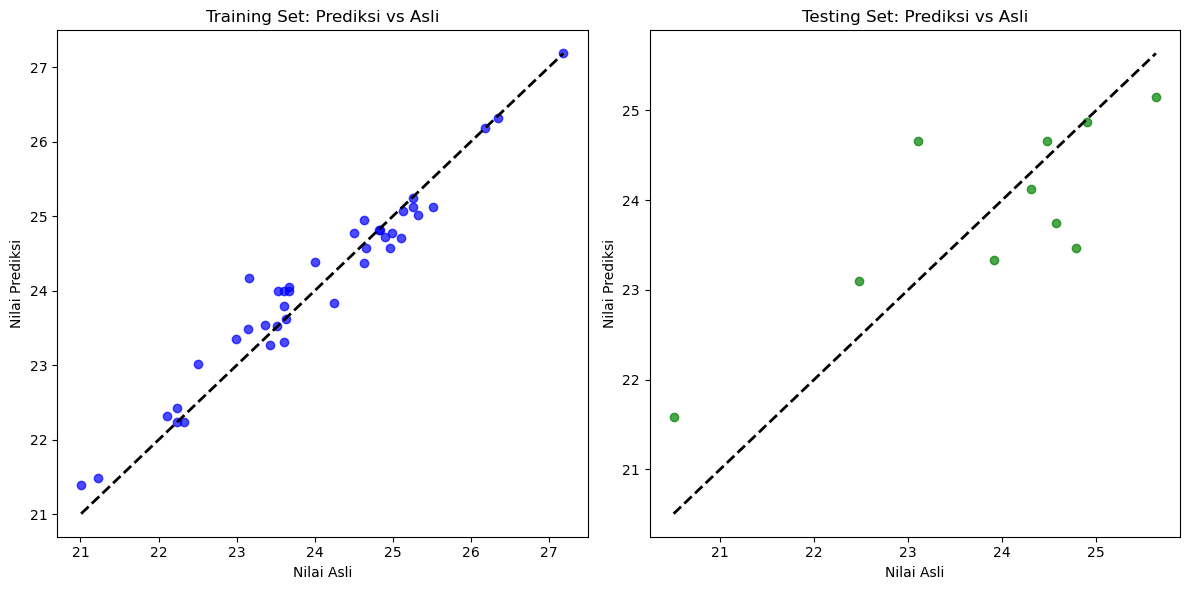

In [98]:
# Menggunakan data asli dari kode sebelumnya
# Pastikan variabel y_train_original, y_train_pred, y_test_original, y_test_pred sudah tersedia

# Buat grafik perbandingan prediksi vs nilai asli untuk training dan testing
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot data training
axes[0].scatter(y_train2, pred_latih, alpha=0.7, color="blue")
axes[0].plot([y_train2.min(), y_train2.max()], 
             [y_train2.min(), y_train2.max()], 'k--', lw=2)
axes[0].set_title("Training Set: Prediksi vs Asli")
axes[0].set_xlabel("Nilai Asli")
axes[0].set_ylabel("Nilai Prediksi")

# Plot data testing
axes[1].scatter(y_test2, pred_test, alpha=0.7, color="green")
axes[1].plot([y_test2.min(), y_test2.max()], 
             [y_test2.min(), y_test2.max()], 'k--', lw=2)
axes[1].set_title("Testing Set: Prediksi vs Asli")
axes[1].set_xlabel("Nilai Asli")
axes[1].set_ylabel("Nilai Prediksi")

plt.tight_layout()
plt.show()

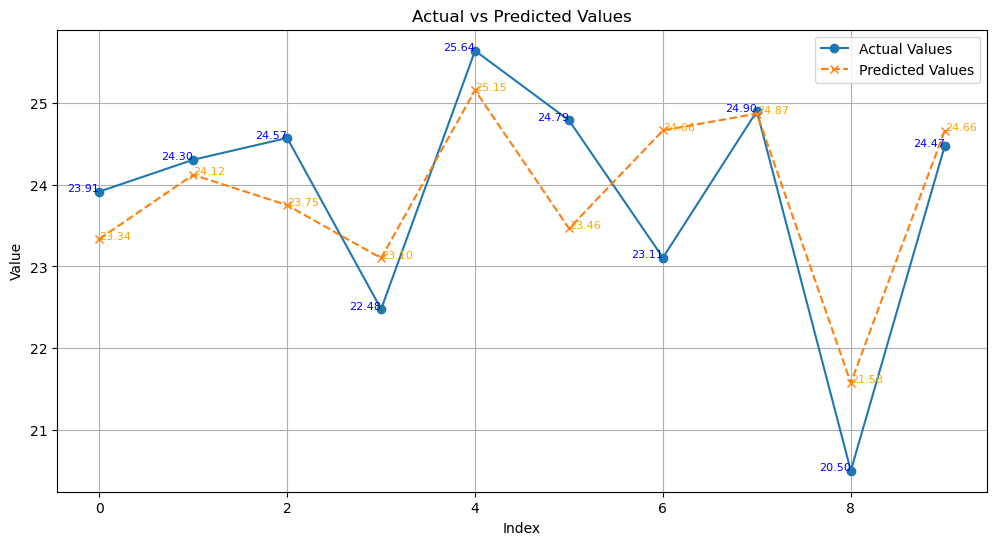

In [99]:
import matplotlib.pyplot as plt
import numpy as np

# Pastikan data berbentuk array (jika tidak, ubah dengan np.array)
y_test = np.array(y_test2)  # Nilai aktual
y_pred = np.array(pred_test)  # Nilai prediksi

# Buat plot
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test2)), y_test2, label='Actual Values', marker='o', linestyle='-')
plt.plot(range(len(y_pred)), y_pred, label='Predicted Values', marker='x', linestyle='--')

# Tambahkan angka di setiap titik
for i, (y_actual, y_predict) in enumerate(zip(y_test, y_pred)):
    plt.text(i, y_actual, f'{y_actual:.2f}', fontsize=8, ha='right', color='blue')
    plt.text(i, y_predict, f'{y_predict:.2f}', fontsize=8, ha='left', color='orange')

# Tambahkan label dan judul
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)

# Tampilkan plot
plt.show()


In [100]:
# Kembalikan nilai logaritma ke skala normal
y_test_normal = np.expm1(y_test2)  # Nilai aktual dalam skala asli
y_pred_normal = np.expm1(y_pred2)  # Nilai prediksi dalam skala asli

# Buat tabel untuk nilai-nilai aktual dan prediksi
index_range = range(len(y_test2))  # Indeks data
data_table = pd.DataFrame({
    'Index': index_range,
    'Actual Values': y_test_normal,
    'Predicted Values': y_pred_normal
})

# Format ke bentuk Rupiah
data_table['Actual Values'] = data_table['Actual Values'].apply(lambda x: f"Rp {x:,.2f}")
data_table['Predicted Values'] = data_table['Predicted Values'].apply(lambda x: f"Rp {x:,.2f}")
data_table

,Index,Actual Values,Predicted Values
41,0,"Rp 24,322,000,000.00","Rp 14,186,639,360.00"
88,1,"Rp 35,905,245,000.00","Rp 20,642,619,392.00"
73,2,"Rp 46,828,450,000.00","Rp 16,964,973,568.00"
98,3,"Rp 5,782,814,827.00","Rp 4,094,739,456.00"
54,4,"Rp 136,000,000,000.00","Rp 84,075,872,256.00"
105,5,"Rp 58,108,499,107.00","Rp 10,699,857,920.00"
65,6,"Rp 10,846,226,018.38","Rp 59,120,357,376.00"
64,7,"Rp 65,000,000,000.00","Rp 80,746,012,672.00"
77,8,"Rp 803,388,207.57","Rp 30,456,535,040.00"
56,9,"Rp 42,500,000,000.00","Rp 52,050,878,464.00"
